In [ ]:
%pip install -qq -U diffusers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 44.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib import pyplot as plt
import torchvision
from torchvision import transforms
from PIL import Image
from torch.utils.data import DataLoader, Dataset
from diffusers import DDPMScheduler
from diffusers import UNet2DModel

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [32]:
def sample(model, noise_scheduler):
  sample = torch.randn(1, 1, 64, 64).to(device)

  store = []

  for i, t in enumerate(noise_scheduler.timesteps):

      with torch.no_grad():
          residual = model(sample, t).sample

      sample = noise_scheduler.step(residual, t, sample).prev_sample

      if i == 0 or (i + 1) % 100 == 0:
        store.append(sample[0])

  f, axarr = plt.subplots(1,11, figsize=(64, 64))
  for i in range(len(store)):
    axarr[i].imshow(store[i].cpu().permute(1, 2, 0))
    axarr[i].axis("off")
  plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/CS 163 - Dark Matter Diffusion/CAMELS CDM data

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/1WreAFow52CZKcX3xQlOydYl9Oj8-Ma5f/CAMELS CDM data


In [34]:
class NPYDataset(Dataset):
    def __init__(self, npy_file, num_samples, transform=None):
        self.data = np.load(npy_file)
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]

        if self.transform:
            sample = self.transform(sample)

        return sample

class LogTransform:
    def __call__(self, x):
        return torch.log(x)  # Adding a small value to avoid log(0)


npy_file = "Maps_Mcdm_IllustrisTNG_LH_z=0.00.npy"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.RandomCrop((64, 64)),
                                LogTransform(),
                                transforms.Normalize((0.0,), (1.0,))])
SIMBA_dataset = NPYDataset(npy_file, num_samples=100, transform=transform)
SIMBA_dataloader = DataLoader(SIMBA_dataset, batch_size=16, shuffle=True)
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

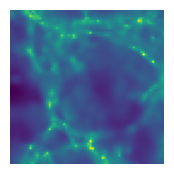

In [38]:
for img in SIMBA_dataloader:
  plt.figure(figsize = (2,2))
  plt.imshow(img[0].permute(1, 2, 0))
  plt.axis("off")
  break

In [37]:
# Create a model
model = UNet2DModel(
    sample_size=64,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(64, 128, 256),  # the number of output channels for each UNet block
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D",
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
    ),
    up_block_types=(
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",
        "UpBlock2D",
    ),
)
model.to(device);

In [39]:
# Training loop
optimizer = torch.optim.AdamW(model.parameters(), lr=4e-4)

losses = []
for epoch in range(30):
    for step, image in enumerate(SIMBA_dataloader):

        clean_images = image.to(device)
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)

        # Get the model prediction
        noise_pred = model(noisy_images, timesteps)[0]

        # Calculate the loss
        loss = F.mse_loss(noise_pred, noise)
        loss.backward(loss)
        losses.append(loss.item())

        # Update the model parameters with the optimizer
        optimizer.step()
        optimizer.zero_grad()

    loss_last_epoch = sum(losses[-len(SIMBA_dataloader):]) / len(SIMBA_dataloader)
    print(f"Epoch {epoch+1} loss: {loss_last_epoch}")

Epoch 1 loss: 0.11396110127531071
Epoch 2 loss: 0.09237540113741655
Epoch 3 loss: 0.08878019792057558
Epoch 4 loss: 0.08743885658018148
Epoch 5 loss: 0.08948335401427898
Epoch 6 loss: 0.08457973487436898
Epoch 7 loss: 0.0840614379288307
Epoch 8 loss: 0.08358156343282604
Epoch 9 loss: 0.08422912683870111
Epoch 10 loss: 0.08472356169041731
Epoch 11 loss: 0.08313061951248567
Epoch 12 loss: 0.08443064078378842
Epoch 13 loss: 0.082917585728694
Epoch 14 loss: 0.08352307792304199
Epoch 15 loss: 0.08330493593123803
Epoch 16 loss: 0.08065929168513589
Epoch 17 loss: 0.08186875552292476
Epoch 18 loss: 0.08368909014349203
Epoch 19 loss: 0.08103741916007738
Epoch 20 loss: 0.0816386240437182
Epoch 21 loss: 0.08182586913805272
Epoch 22 loss: 0.08190327552633721
Epoch 23 loss: 0.08264350894588365
Epoch 24 loss: 0.08133767624852309
Epoch 25 loss: 0.08225348971879431
Epoch 26 loss: 0.08415369044985375
Epoch 27 loss: 0.08192334195741935
Epoch 28 loss: 0.0819648655969451
Epoch 29 loss: 0.08117919632676504

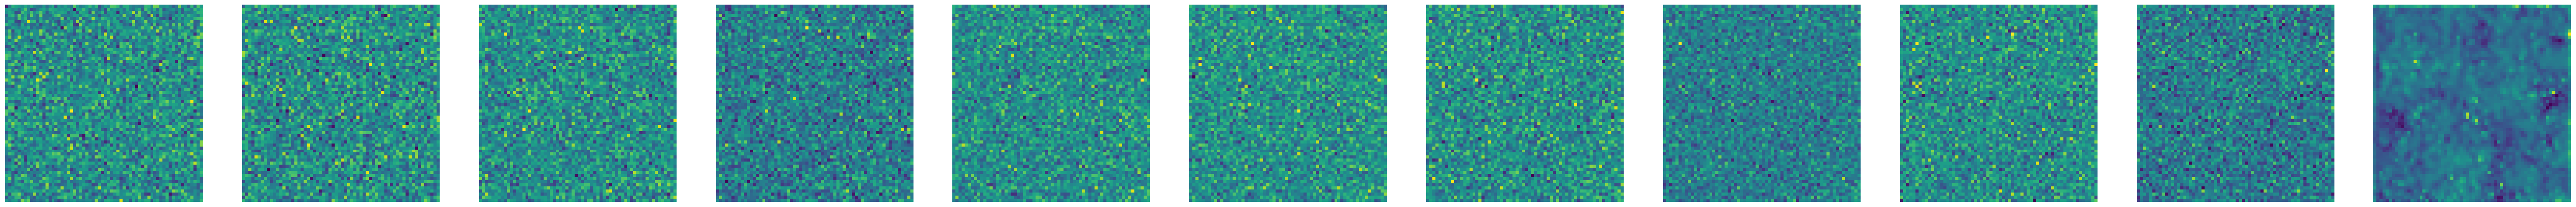

In [47]:
sample(model, noise_scheduler)